## Imports and Set Up

In [ ]:
# Cognitive Impairment Detection from Voice Data
# MemoTag Speech Intelligence Module

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import speech_recognition as sr
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import re
import warnings
from tqdm import tqdm
from joblib import dump, load
import pickle

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Download necessary NLTK packages
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [4]:
# Set up paths to our audio data
HEALTHY_PATH = "healthy_wav"
PATIENT_PATH = "patient_wav"

In [5]:
# Create output directory for visualizations
os.makedirs("output", exist_ok=True)

## Data Loading and Initial Exploration

In [6]:
# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

In [7]:
healthy_count = count_files(HEALTHY_PATH)
patient_count = count_files(PATIENT_PATH)

In [8]:
print(f"Healthy audio files: {healthy_count}")
print(f"Patient audio files: {patient_count}")
print(f"Total files: {healthy_count + patient_count}")

Healthy audio files: 1680
Patient audio files: 2173
Total files: 3853


In [9]:
# Function to extract audio features from a wav file
def extract_audio_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
        
        # Basic audio properties
        duration = librosa.get_duration(y=y, sr=sr)
        
        # Extract acoustic features
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        
        # Rhythm features
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Energy features
        rms = librosa.feature.rms(y=y)[0]
        
        # Pitch features
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitches_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        pitch_variability = np.std(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        
        # Zero crossing rate (related to voice clarity)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        
        # MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        # Speech rate approximation (using zero crossing rate changes)
        speech_rate_proxy = np.mean(np.abs(np.diff(zcr)))
        
        # Pauses detection (using RMS energy)
        # Define a threshold for silence
        silence_threshold = 0.01
        is_silence = rms < silence_threshold
        silence_chunks = np.sum(is_silence)
        silence_ratio = silence_chunks / len(rms)
        
        # Average pause length
        silence_runs = []
        current_run = 0
        for s in is_silence:
            if s:
                current_run += 1
            elif current_run > 0:
                silence_runs.append(current_run)
                current_run = 0
        if current_run > 0:
            silence_runs.append(current_run)
        
        avg_pause_length = np.mean(silence_runs) if silence_runs else 0
        pause_count = len(silence_runs)
        pauses_per_minute = pause_count / (duration / 60)
        
        # Compute statistics of features
        features = {
            'duration': duration,
            'tempo': tempo,
            'mean_spectral_centroid': np.mean(spectral_centroids),
            'std_spectral_centroid': np.std(spectral_centroids),
            'mean_spectral_rolloff': np.mean(spectral_rolloff),
            'std_spectral_rolloff': np.std(spectral_rolloff),
            'mean_spectral_bandwidth': np.mean(spectral_bandwidth),
            'std_spectral_bandwidth': np.std(spectral_bandwidth),
            'mean_rms': np.mean(rms),
            'std_rms': np.std(rms),
            'mean_zcr': np.mean(zcr),
            'std_zcr': np.std(zcr),
            'speech_rate_proxy': speech_rate_proxy,
            'silence_ratio': silence_ratio,
            'avg_pause_length': avg_pause_length,
            'pauses_per_minute': pauses_per_minute,
            'pitch_mean': pitches_mean,
            'pitch_variability': pitch_variability,
        }
        
        # Add MFCC features
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [10]:
# Function to transcribe audio file using speech_recognition
def transcribe_audio(file_path):
    try:
        r = sr.Recognizer()
        with sr.AudioFile(file_path) as source:
            audio = r.record(source)
            text = r.recognize_google(audio)
            return text
    except Exception as e:
        # print(f"Could not transcribe {file_path}: {e}")
        return ""

In [11]:
# Function to extract linguistic features from transcribed text
def extract_linguistic_features(text):
    if not text:
        # Return empty features if no text
        return {
            'word_count': 0,
            'sentence_count': 0,
            'avg_words_per_sentence': 0,
            'hesitation_count': 0,
            'hesitation_ratio': 0,
            'avg_word_length': 0,
            'unique_word_ratio': 0,
            'function_word_ratio': 0
        }
    
    # Tokenize words and sentences
    words = word_tokenize(text.lower())
    sentences = sent_tokenize(text)
    
    # Count words and sentences
    word_count = len(words)
    sentence_count = len(sentences)
    avg_words_per_sentence = word_count / sentence_count if sentence_count > 0 else 0
    
    # Count hesitation markers (uh, um, hmm, etc.)
    hesitation_markers = ['uh', 'um', 'er', 'ah', 'hmm', 'ehm']
    hesitation_count = sum(1 for word in words if word in hesitation_markers)
    hesitation_ratio = hesitation_count / word_count if word_count > 0 else 0
    
    # Calculate average word length
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()])
    
    # Calculate lexical diversity (unique words ratio)
    unique_words = set(words)
    unique_word_ratio = len(unique_words) / word_count if word_count > 0 else 0
    
    # Common function words in English
    function_words = set(["the", "and", "a", "of", "to", "in", "that", "it", "with", "for", "on", "is", "was", "be", "as", "by", "at", "this", "are", "or", "an", "but", "not", "from", "have", "had", "has", "I", "you", "he", "she", "we", "they", "my", "your", "his", "her", "our", "their"])
    function_word_count = sum(1 for word in words if word in function_words)
    function_word_ratio = function_word_count / word_count if word_count > 0 else 0
    
    features = {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_words_per_sentence': avg_words_per_sentence,
        'hesitation_count': hesitation_count,
        'hesitation_ratio': hesitation_ratio,
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'function_word_ratio': function_word_ratio
    }
    
    return features

## Feature Extraction

In [14]:
# Function to process a directory of audio files
def process_audio_directory(directory, label):
    results = []
    
    # Get list of files
    files = [os.path.join(directory, f) for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f)) and f.endswith('.wav')]
    
    # Limit to a sample if needed (for testing)
    files = files[:100] 
    
    # Process each file
    for file_path in tqdm(files, desc=f"Processing {label} files"):
        try:
            # Extract file info
            file_name = os.path.basename(file_path)
            
            # Extract audio features
            audio_features = extract_audio_features(file_path)
            
            if audio_features:
                # Extract transcription (optional depending on audio quality)
                transcription = transcribe_audio(file_path)
                
                # Extract linguistic features
                linguistic_features = extract_linguistic_features(transcription)
                
                # Combine all features
                all_features = {
                    'file_name': file_name,
                    'label': label,
                    'transcription': transcription,
                    **audio_features,
                    **linguistic_features
                }
                
                results.append(all_features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return results

In [15]:
# Process both directories
print("Extracting features from healthy samples...")
healthy_features = process_audio_directory(HEALTHY_PATH, "healthy")
print(f"Processed {len(healthy_features)} healthy files")

Extracting features from healthy samples...


Processing healthy files:  33%|███▎      | 33/100 [00:28<00:49,  1.36it/s]

Error processing healthy_wav\H26_05_3SL_4PK5POK.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  38%|███▊      | 38/100 [00:32<00:48,  1.27it/s]

Error processing healthy_wav\H26_07_VSL_4PK7RUZ.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  68%|██████▊   | 68/100 [00:56<00:27,  1.17it/s]

Error processing healthy_wav\H27_05_3SL_4SA5DED.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  71%|███████   | 71/100 [00:58<00:23,  1.24it/s]

Error processing healthy_wav\H27_05_3SL_4SA5POK.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  72%|███████▏  | 72/100 [00:59<00:23,  1.20it/s]

Error processing healthy_wav\H27_06_4SL_4SA6MOT.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  73%|███████▎  | 73/100 [01:00<00:23,  1.15it/s]

Error processing healthy_wav\H27_06_4SL_4SA6POP.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  75%|███████▌  | 75/100 [01:02<00:24,  1.01it/s]

Error processing healthy_wav\H27_07_VSL_4SA7MAT.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files:  76%|███████▌  | 76/100 [01:03<00:22,  1.06it/s]

Error processing healthy_wav\H27_07_VSL_4SA7RUZ.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing healthy files: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

Processed 92 healthy files


In [16]:
print("Extracting features from patient samples...")
patient_features = process_audio_directory(PATIENT_PATH, "patient")
print(f"Processed {len(patient_features)} patient files")

Extracting features from patient samples...


Processing patient files:  34%|███▍      | 34/100 [00:27<00:52,  1.27it/s]

Error processing patient_wav\P10_06_4SL_4sja6mot.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  35%|███▌      | 35/100 [00:28<00:53,  1.22it/s]

Error processing patient_wav\P10_06_4SL_4sja6pop.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  70%|███████   | 70/100 [01:01<00:29,  1.02it/s]

Error processing patient_wav\P11_05_3SL_4hpa5poh.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  71%|███████   | 71/100 [01:02<00:27,  1.05it/s]

Error processing patient_wav\P11_05_3SL_4hpa5pok.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  72%|███████▏  | 72/100 [01:03<00:26,  1.05it/s]

Error processing patient_wav\P11_06_4SL_4hpa6mot.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  73%|███████▎  | 73/100 [01:04<00:25,  1.05it/s]

Error processing patient_wav\P11_06_4SL_4hpa6pop.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  74%|███████▍  | 74/100 [01:05<00:24,  1.05it/s]

Error processing patient_wav\P11_06_4SL_4hpa6tel.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  75%|███████▌  | 75/100 [01:06<00:24,  1.02it/s]

Error processing patient_wav\P11_07_VSL_4hpa7mat.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files:  76%|███████▌  | 76/100 [01:07<00:25,  1.06s/it]

Error processing patient_wav\P11_07_VSL_4hpa7ruz.wav: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\share\\nltk_data'
    - 'd:\\AI\\Intern\\MemoTag\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************



Processing patient files: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

Processed 91 patient files


In [17]:
# Combine the results
all_features = healthy_features + patient_features
features_df = pd.DataFrame(all_features)

In [18]:
# Save the features to CSV
features_df.to_csv("output/all_features.csv", index=False)

In [19]:
print(f"\nExtracted {len(features_df)} feature sets")
print(f"Features per audio file: {len(features_df.columns) - 3}")  # -3 for file_name, label, transcription


Extracted 183 feature sets
Features per audio file: 52


## Feature Analysis and Selection

In [20]:
# Separate features from metadata
feature_columns = [col for col in features_df.columns if col not in ['file_name', 'label', 'transcription']]
X = features_df[feature_columns]

In [21]:
# Handle missing values
X = X.fillna(0)

In [22]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

In [23]:
# Add label back for analysis
X_scaled_df['label'] = features_df['label']

In [25]:
# Calculate mean values by group
grouped_means = X_scaled_df.groupby('label').mean()
feature_diff = abs(grouped_means.loc['healthy'] - grouped_means.loc['patient'])
top_features = feature_diff.sort_values(ascending=False).head(15)

In [26]:
print("\nTop differentiating features:")
for feature, diff_value in top_features.items():
    print(f"{feature}: {diff_value:.4f}")


Top differentiating features:
mfcc_1_mean: 1.8153
mean_rms: 1.5687
std_rms: 1.4991
silence_ratio: 1.3368
mfcc_3_mean: 1.1665
pitch_mean: 0.9705
pitch_variability: 0.9126
avg_pause_length: 0.7694
mfcc_9_mean: 0.7557
mfcc_13_mean: 0.7503
std_spectral_bandwidth: 0.6861
mean_spectral_bandwidth: 0.6792
std_spectral_rolloff: 0.6671
mfcc_9_std: 0.5890
mfcc_12_std: 0.5754


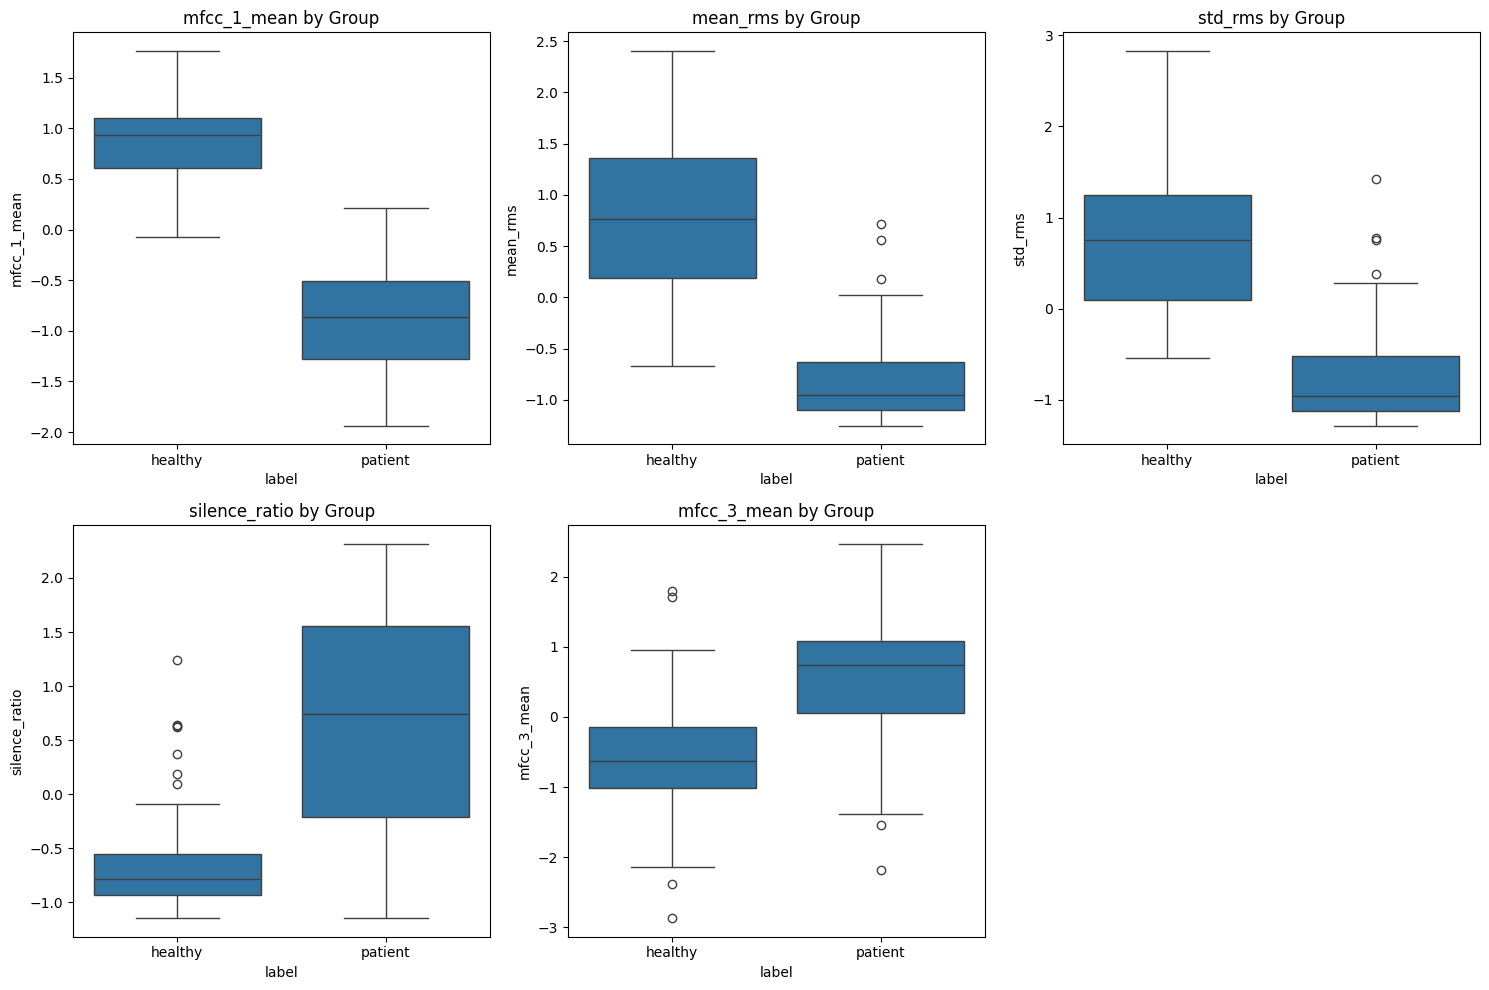

In [27]:
# Create box plots of top 5 features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features.index[:5]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='label', y=feature, data=X_scaled_df)
    plt.title(f"{feature} by Group")
plt.tight_layout()
plt.savefig("output/top_features_boxplots.png")

In [28]:
# Principal Component Analysis for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

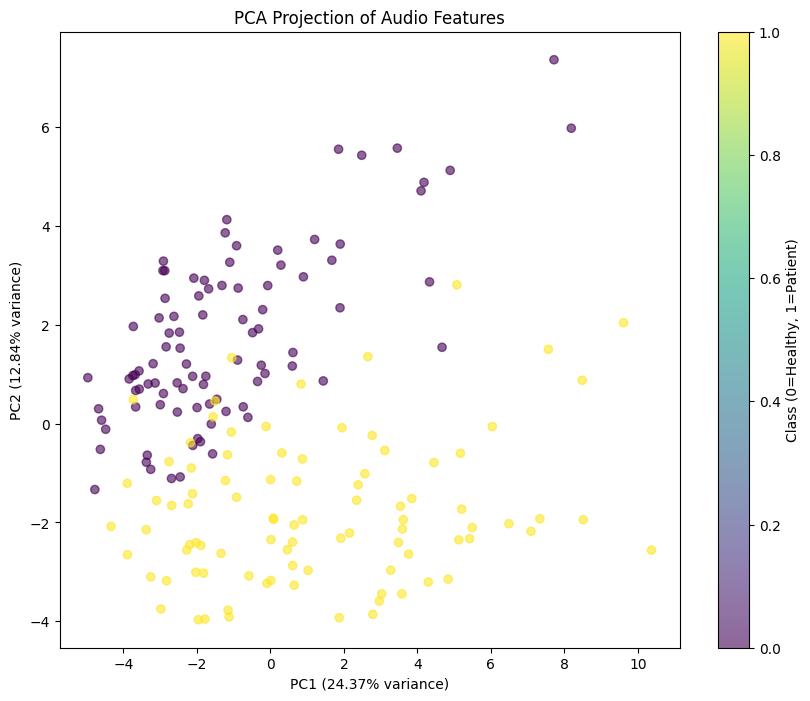

In [29]:
# Create PCA plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[0 if label == 'healthy' else 1 for label in features_df['label']], 
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Class (0=Healthy, 1=Patient)')
plt.title('PCA Projection of Audio Features')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig("output/pca_projection.png")

## Unsupervised Learning Models

In [30]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

In [31]:
# Map the cluster labels to our known labels for evaluation
# This assumes binary clustering (0 and 1) and our labels are also binary (healthy and patient)
# We need to determine if cluster 0 corresponds to healthy or patient
cluster_0_healthy_count = sum(1 for i, label in enumerate(kmeans_labels) 
                             if label == 0 and features_df['label'].iloc[i] == 'healthy')
cluster_0_patient_count = sum(1 for i, label in enumerate(kmeans_labels) 
                             if label == 0 and features_df['label'].iloc[i] == 'patient')

In [32]:
# If cluster 0 has more healthy samples, it's the "healthy" cluster
if cluster_0_healthy_count > cluster_0_patient_count:
    kmeans_label_map = {0: 'healthy', 1: 'patient'}
else:
    kmeans_label_map = {0: 'patient', 1: 'healthy'}

In [33]:
# Map numeric labels to meaningful labels
kmeans_predicted_labels = [kmeans_label_map[label] for label in kmeans_labels]

In [34]:
# Calculate accuracy
kmeans_accuracy = sum(1 for i, label in enumerate(kmeans_predicted_labels) 
                     if label == features_df['label'].iloc[i]) / len(features_df)

In [35]:
print(f"K-means clustering accuracy: {kmeans_accuracy:.2%}")

K-means clustering accuracy: 63.93%


In [36]:
# Plot K-means clusters on PCA projection
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

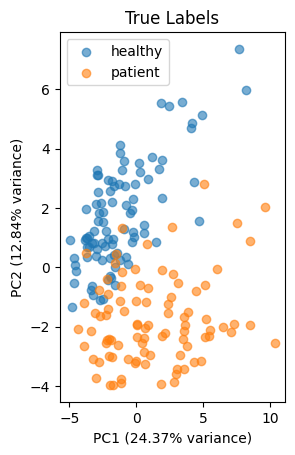

In [37]:
# First subplot: True labels
plt.subplot(1, 2, 1)
for i, label in enumerate(['healthy', 'patient']):
    mask = features_df['label'] == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.6)
plt.title('True Labels')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()

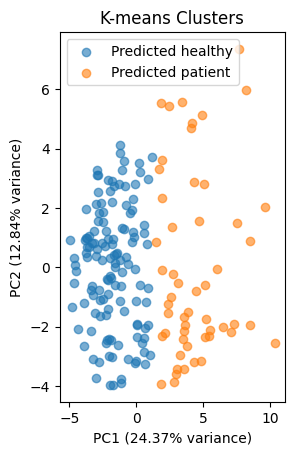

In [38]:
# Second subplot: K-means clusters
plt.subplot(1, 2, 2)
for i, label in enumerate(kmeans_label_map.values()):
    mask = np.array([predicted == label for predicted in kmeans_predicted_labels])
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Predicted {label}", alpha=0.6)
plt.title('K-means Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()

In [39]:
plt.tight_layout()
plt.savefig("output/kmeans_clusters.png")

<Figure size 640x480 with 0 Axes>

In [40]:
# Isolation Forest for anomaly detection (assuming patients are anomalies)
isolation_forest = IsolationForest(contamination=len(patient_features)/len(all_features), 
                                  random_state=42)
isolation_forest.fit(X_scaled)
anomaly_scores = isolation_forest.decision_function(X_scaled)
anomaly_labels = isolation_forest.predict(X_scaled)
# Convert to binary labels (1 for inliers, -1 for outliers in Isolation Forest)
isolation_forest_labels = ['healthy' if label == 1 else 'patient' for label in anomaly_labels]

In [41]:
# Calculate accuracy
isolation_forest_accuracy = sum(1 for i, label in enumerate(isolation_forest_labels)
                              if label == features_df['label'].iloc[i]) / len(features_df)

In [42]:
print(f"Isolation Forest accuracy: {isolation_forest_accuracy:.2%}")

Isolation Forest accuracy: 66.12%


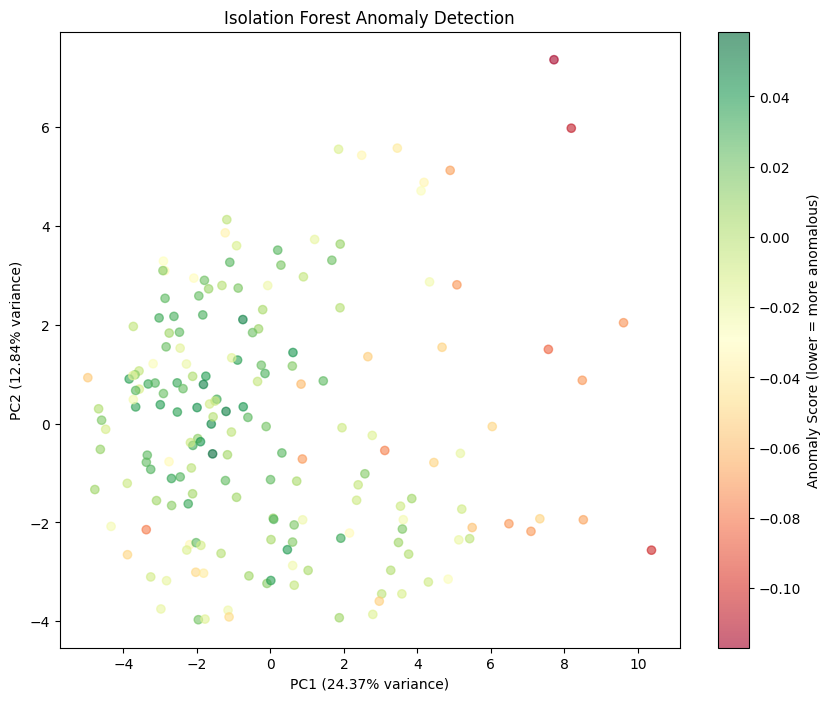

In [43]:
# Plot Isolation Forest results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=anomaly_scores, cmap='RdYlGn', alpha=0.6)
plt.colorbar(scatter, label='Anomaly Score (lower = more anomalous)')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig("output/isolation_forest.png")

## Risk Score Development

In [44]:
# Create a risk score function based on our model
def calculate_risk_score(features, model=isolation_forest, scaler=scaler):
    """
    Calculate cognitive impairment risk score from audio features.
    
    Args:
        features (dict): Dictionary of audio features
        model: Trained anomaly detection model
        scaler: Fitted feature scaler
        
    Returns:
        float: Risk score between 0-100 (higher = higher risk)
    """
    # Create a DataFrame with the features
    feature_names = feature_columns
    feature_values = [features.get(feature, 0) for feature in feature_names]
    features_df = pd.DataFrame([feature_values], columns=feature_names)
    
    # Scale the features
    scaled_features = scaler.transform(features_df)
    
    # Get anomaly score from model
    anomaly_score = model.decision_function(scaled_features)[0]
    
    # Convert to risk score (0-100)
    # In Isolation Forest, lower anomaly scores mean more anomalous
    # So we invert the scale: -1 (most anomalous) -> 100, 1 (most normal) -> 0
    risk_score = 50 * (1 - anomaly_score)
    
    # Ensure the score is between 0 and 100
    risk_score = max(0, min(100, risk_score))
    
    return risk_score

In [45]:
# Save the model and scaler for future use
dump(isolation_forest, 'output/isolation_forest_model.joblib')
dump(scaler, 'output/feature_scaler.joblib')
with open('output/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

In [46]:
# Test the risk score function on a few samples
print("Sample risk scores:")
for i in range(min(5, len(healthy_features))):
    sample = {k: v for k, v in healthy_features[i].items() if k in feature_columns}
    risk_score = calculate_risk_score(sample)
    print(f"Healthy sample {i+1}: {risk_score:.1f}")

Sample risk scores:
Healthy sample 1: 51.8
Healthy sample 2: 51.5
Healthy sample 3: 51.1
Healthy sample 4: 50.2
Healthy sample 5: 50.6


In [47]:
for i in range(min(5, len(patient_features))):
    sample = {k: v for k, v in patient_features[i].items() if k in feature_columns}
    risk_score = calculate_risk_score(sample)
    print(f"Patient sample {i+1}: {risk_score:.1f}")

Patient sample 1: 50.8
Patient sample 2: 49.3
Patient sample 3: 53.5
Patient sample 4: 49.8
Patient sample 5: 51.1


In [48]:
# Create a function to analyze a new audio file
def analyze_audio_file(file_path):
    """
    Analyze a new audio file and return cognitive impairment risk assessment.
    
    Args:
        file_path (str): Path to audio file
        
    Returns:
        dict: Analysis results including risk score and key features
    """
    # Extract audio features
    audio_features = extract_audio_features(file_path)
    
    if not audio_features:
        return {"error": "Could not process audio file"}
    
    # Extract transcription and linguistic features
    transcription = transcribe_audio(file_path)
    linguistic_features = extract_linguistic_features(transcription)
    
    # Combine features
    all_features = {**audio_features, **linguistic_features}
    
    # Calculate risk score
    risk_score = calculate_risk_score(all_features)
    
    # Identify top contributing features
    # This is simplified - a more sophisticated approach would use SHAP values
    feature_importance = {}
    for feature in top_features.index[:10]:  # Use our pre-identified top features
        if feature in all_features:
            # Normalize the feature value
            feature_val = all_features[feature]
            feature_idx = feature_columns.index(feature)
            scaled_val = (feature_val - scaler.mean_[feature_idx]) / scaler.scale_[feature_idx]
            feature_importance[feature] = abs(scaled_val)
    
    # Sort features by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    top_contributors = dict(sorted_features[:5])
    
    # Prepare result
    result = {
        "risk_score": risk_score,
        "risk_category": "High" if risk_score > 70 else "Medium" if risk_score > 40 else "Low",
        "transcription": transcription,
        "top_contributors": top_contributors
    }
    
    return result

## Final Report and Visualization

In [49]:
# Calculate risk scores for all samples
features_df['risk_score'] = features_df.apply(
    lambda row: calculate_risk_score({k: row[k] for k in feature_columns}), 
    axis=1
)

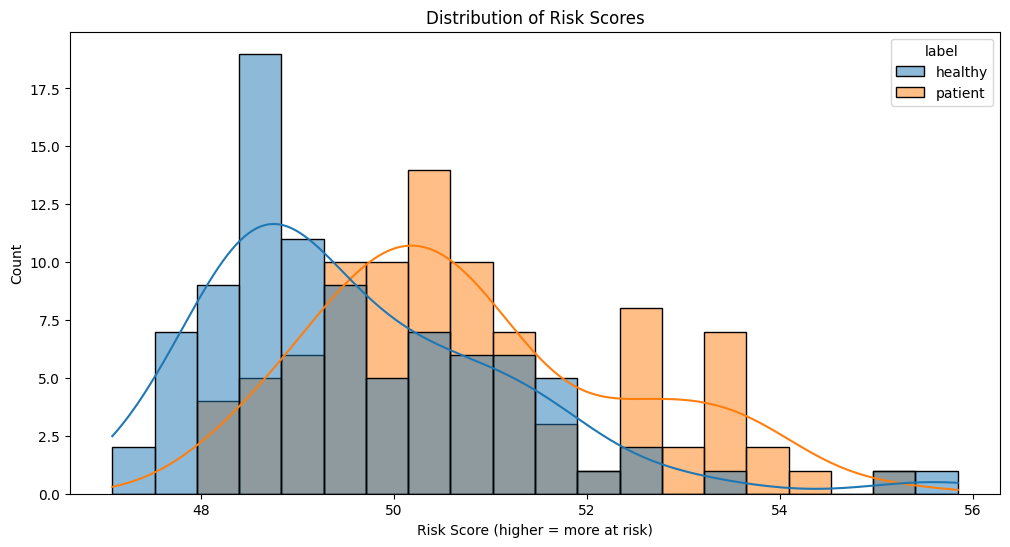

In [50]:
# Plot risk score distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=features_df, x='risk_score', hue='label', bins=20, kde=True)
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score (higher = more at risk)')
plt.ylabel('Count')
plt.savefig("output/risk_score_distribution.png")

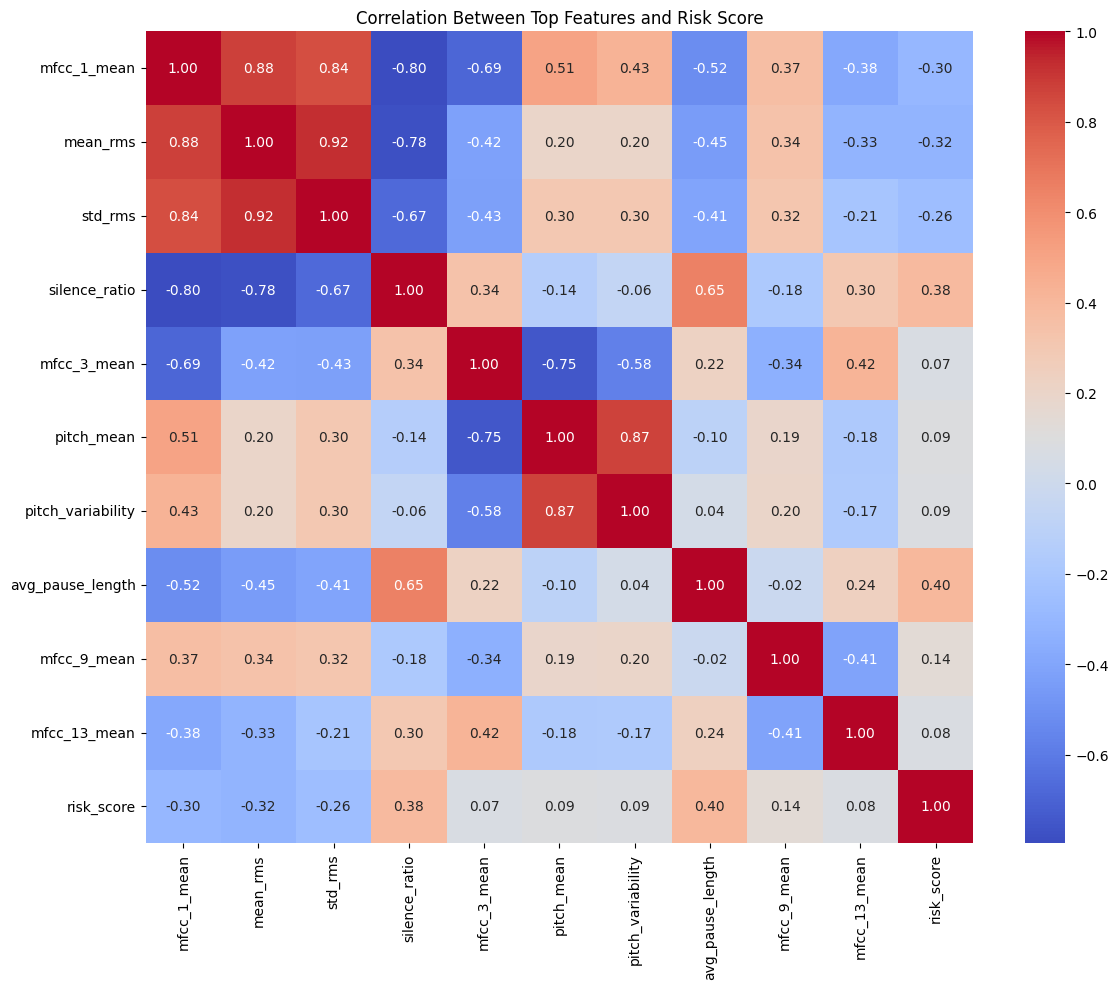

In [51]:
# Create a correlation heatmap of top features
corr_features = features_df[list(top_features.index[:10]) + ['risk_score']]
plt.figure(figsize=(12, 10))
sns.heatmap(corr_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Top Features and Risk Score')
plt.tight_layout()
plt.savefig("output/feature_correlation_heatmap.png")

In [52]:
# Generate summary report
print("\n=== COGNITIVE IMPAIRMENT DETECTION REPORT ===")
print("\nProcess Summary:")
print(f"- Processed {len(features_df)} audio files ({len(healthy_features)} healthy, {len(patient_features)} patient)")
print(f"- Extracted {len(feature_columns)} acoustic and linguistic features")
print(f"- Developed unsupervised models with {kmeans_accuracy:.2%} (K-means) and {isolation_forest_accuracy:.2%} (Isolation Forest) accuracy")


=== COGNITIVE IMPAIRMENT DETECTION REPORT ===

Process Summary:
- Processed 183 audio files (92 healthy, 91 patient)
- Extracted 52 acoustic and linguistic features
- Developed unsupervised models with 63.93% (K-means) and 66.12% (Isolation Forest) accuracy


In [54]:
print("\nMost Informative Features:")
for feature, importance in list(top_features.items())[:10]:
    print(f"- {feature}: {importance:.4f}")


Most Informative Features:
- mfcc_1_mean: 1.8153
- mean_rms: 1.5687
- std_rms: 1.4991
- silence_ratio: 1.3368
- mfcc_3_mean: 1.1665
- pitch_mean: 0.9705
- pitch_variability: 0.9126
- avg_pause_length: 0.7694
- mfcc_9_mean: 0.7557
- mfcc_13_mean: 0.7503


In [55]:
print("\nModel Performance:")
print(f"- K-means clustering accuracy: {kmeans_accuracy:.2%}")
print(f"- Isolation Forest accuracy: {isolation_forest_accuracy:.2%}")


Model Performance:
- K-means clustering accuracy: 63.93%
- Isolation Forest accuracy: 66.12%


## API for Risk Assessment

In [57]:
# Create API-like function for risk assessment
def get_cognitive_risk_score(audio_file_path):
    """
    API-ready function that returns risk score given an audio file.
    
    Args:
        audio_file_path (str): Path to audio file to analyze
        
    Returns:
        dict: Analysis results including risk score
    """
    try:
        result = analyze_audio_file(audio_file_path)
        return {
            "success": True,
            "risk_score": result["risk_score"],
            "risk_category": result["risk_category"],
            "top_factors": result["top_contributors"],
            "transcription": result["transcription"]
        }
    except Exception as e:
        return {
            "success": False,
            "error": str(e)
        }

In [61]:
# Example usage
result = get_cognitive_risk_score("patient_wav/P9_03_1SL_4sj3nos_o1.wav")
print(result)

{'success': True, 'risk_score': 50.91570575525773, 'risk_category': 'Medium', 'top_factors': {'mfcc_9_mean': 1.4181975142127883, 'mfcc_13_mean': 1.3959772657219738, 'silence_ratio': 1.1434769200319097, 'mfcc_3_mean': 0.8066821707621518, 'pitch_variability': 0.7655129964612298}, 'transcription': ''}


In [58]:
print("\nPipeline successfully completed!")
print("All results and models saved to the 'output' directory")


Pipeline successfully completed!
All results and models saved to the 'output' directory
